In [1]:
%load_ext autoreload
%autoreload 2

Number of samples: 5108


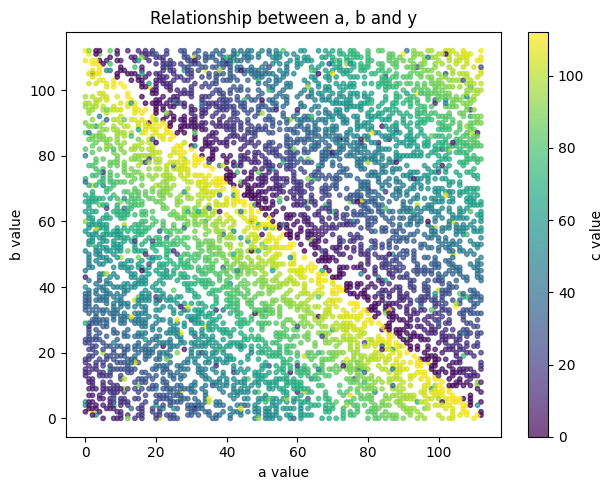

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from datasets.arithmetic import ModArithmeticCpDataset, get_mod_arithmetic_cp_dataloaders, ArithmeticDatasetConfig
from arithmetic.vis import visualize_data

config = ArithmeticDatasetConfig(
  p=113,
  noise_frac=0.1
)

train_dataloader, val_dataloader, _ = get_mod_arithmetic_cp_dataloaders(data_config=config, batch_size=256, val_frac=0.6)

visualize_data(train_dataloader)

data_iter = iter(train_dataloader)

In [28]:
class Embed(nn.Module):
    def __init__(self, n_vocab, d_model):
        super().__init__()
        self.W_embed = nn.Parameter(t.randn(d_model, n_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
      return t.einsum('dbp -> bpd', self.W_embed[:, x])


class Unembed(nn.Module):
  def __init__(self, n_vocab, d_model):
    super().__init__()
    self.W_ue = nn.Parameter(t.randn(d_model, n_vocab)/np.sqrt(d_model))
  
  def forward(self, x):
    return x @ self.W_ue


class PosEmbed(nn.Module):
  def __init__(self, d_model, seq_len):
    super().__init__()
    self.W_pos = nn.Parameter(t.randn(seq_len, d_model)/np.sqrt(d_model))
    
  def forward(self, x):
    in_seq_len = x.shape[-2]
    return x + self.W_pos[:in_seq_len]


class LayerNorm(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.e = 1e-6
    self.w = nn.Parameter(t.ones(in_dim))
    self.b = nn.Parameter(t.zeros(in_dim))
    
  def forward(self, x):
    return self.w * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.e) + self.b
    

class Attention(nn.Module):
  def __init__(self, d_model, n_heads, max_seq_len):
    super().__init__()

    assert d_model % n_heads == 0, "embed_dim must be divisible by num_heads"
    self.head_dim = d_model // n_heads

    self.W_qkv = nn.Parameter(t.randn(n_heads, d_model, self.head_dim * 3)/np.sqrt(d_model))
    self.W_out = nn.Parameter(t.randn(n_heads, self.head_dim, self.head_dim * n_heads)/np.sqrt(d_model))

    # Matrix of 0s on the lower traingular part, and a large negative number everywhere else
    self.register_buffer('mask', - 1e10 * (1-t.tril(t.ones((max_seq_len, max_seq_len), dtype=t.float32))))

  def forward(self, x):
    qkv = t.einsum('bsd,ndh -> bnsh', x, self.W_qkv) # batch, n_heads, seq_len, head_dim * 3
    q, k, v = t.chunk(qkv, 3, dim=-1) # batch, n_heads, seq_len, head_dim
    attn = t.einsum('bnqh,bnkh -> bnqk', q, k) / np.sqrt(self.head_dim) # batch, n_heads, seq_len_q, seq_len_k
    attn = attn + self.mask[:attn.shape[-2], :attn.shape[-2]]
    attn = F.softmax(attn, dim=-1)
    
    out = t.einsum('bnqk,bnkh -> bnqh', attn, v) # batch, n_heads, seq_len_q, head_dim
    out = out.reshape(out.shape[0], -1, out.shape[-2]) # batch, d_model, seq_len
    out = t.einsum('bds,nhd -> bsd', out, self.W_out) # batch, seq_len, d_model
    
    return out


class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dim):
    super().__init__()
    self.fc1 = nn.Linear(in_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, out_dim)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


class TransformerBlock(nn.Module):
  def __init__(self, d_model, max_seq_len, n_heads, d_mlp):
    super().__init__()
    
    self.ln1 = LayerNorm(d_model)
    self.attention = Attention(d_model, n_heads, max_seq_len)
    self.ln2 = LayerNorm(d_model)
    self.mlp = MLP(d_model, d_model, hidden_dim=d_mlp)

  def forward(self, x):
    x = x + self.attention(self.ln1(x))
    x = x + self.mlp(self.ln2(x))
    return x


class Transformer(nn.Module):
  def __init__(self, d_model, n_vocab, max_seq_len, n_heads, n_layers, d_mlp):
    super().__init__()
    
    self.embedding = Embed(n_vocab=n_vocab, d_model=d_model)
    self.pos_embedding = PosEmbed(d_model=d_model, seq_len=max_seq_len)
    
    self.transformer_blocks = nn.ModuleList([
      TransformerBlock(d_model=d_model, max_seq_len=max_seq_len, n_heads=n_heads, d_mlp=d_mlp)
      for _ in range(n_layers)
    ])
    
    self.ln = LayerNorm(d_model)
    self.unembed = Unembed(n_vocab=config.p, d_model=d_model)

  def forward(self, x):
    x = self.embedding(x)
    x = self.pos_embedding(x)
    
    for transformer in self.transformer_blocks:
      x = transformer(x)
    
    x = self.ln(x)
    x = self.unembed(x)
    
    return x


transformer = Transformer(
  d_model=32,
  n_vocab=config.p,
  max_seq_len=2,
  n_heads=4,
  n_layers=1,
  d_mlp=32
)

sum(t.numel(p) for p in transformer.parameters())


def eval_model(model: nn.Module, val_dataloader: t.utils.data.DataLoader, device: t.device):
    model.eval()
    total_loss = 0.0
    with t.no_grad():
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)[:, -1, :]
            
            print(pred.shape, y.shape)
            loss = F.mse_loss(pred, y)
            total_loss += loss.item()
    return total_loss / len(val_dataloader)



In [29]:
eval_model(transformer, val_dataloader, device=t.device('cpu'))

torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size([256, 113])
torch.Size([256, 113]) torch.Size(

0.8981581866741181